In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import catboost as cb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

In [3]:
from sklearn.metrics import classification_report

# Data

## Import data

In [4]:
sku_dict= pd.read_csv('sku_dict.csv')

In [5]:
ZX_df = pd.read_csv('ZX10208_agr.csv')


In [6]:
df_1510001 = pd.read_csv('1510001_agr.csv')

In [7]:
df_1510002 = pd.read_csv('1510002_agr.csv')

In [8]:
df_1510003 = pd.read_csv('1510003_agr.csv')

In [9]:
conc_df = pd.read_csv('conc_df.csv')

In [10]:
promo_df = pd.read_csv('promo_1510002.csv')

In [11]:
promo_df[:3]

,year,week_num,SKU,discount
0,2019,1,90611,0.9
1,2019,2,10334,0.9
2,2019,3,68211,0.9


In [12]:
conc_df[:3]

,SKU,year,week_num,ret_net_code,price_per_sku
0,84395,2019,18,1,164.6940
1,84395,2019,18,2,164.6940
2,84395,2019,18,3,134.5001


In [13]:
df_1510003[:3]

,dates,SKU,price_per_sku,num_purchases
0,2018-11-17,54404,80.095,11
1,2018-11-18,54404,80.095,12
2,2018-11-19,54404,81.796,10


In [14]:
df_1510002[:3]

,dates,SKU,price_per_sku,num_purchases
0,2018-01-24,72784,124.294,9
1,2018-01-25,72784,124.294,9
2,2018-01-27,72784,124.294,7


In [15]:
df_1510001[:3]

,dates,SKU,price_per_sku,num_purchases
0,2018-08-02,39665,85.94,1
1,2018-08-03,39665,85.94,1
2,2018-08-04,39665,85.94,1


In [16]:
ZX_df[:3]

,dates,SKU,price_per_sku,num_purchases
0,2018-04-20,59567,169.19,3
1,2018-04-24,59567,171.71,3
2,2018-04-27,59567,174.04,3


## Data preprocessing

In [17]:
all_data = pd.concat([df_1510001, df_1510002, df_1510003, ZX_df], axis = 0 )

In [18]:
all_data.dates = pd.to_datetime(all_data.dates)

In [19]:
all_data['Mon_Year']=all_data['dates'].dt.strftime('%b-%Y')

In [20]:
all_data.head()

,dates,SKU,price_per_sku,num_purchases,Mon_Year
0,2018-08-02,39665,85.940,1,Aug-2018
1,2018-08-03,39665,85.940,1,Aug-2018
2,2018-08-04,39665,85.940,1,Aug-2018
3,2018-08-05,39665,85.940,1,Aug-2018
4,2018-08-06,39665,86.038,1,Aug-2018


In [21]:
all_data.Mon_Year=pd.to_datetime(all_data.Mon_Year)

In [22]:
all_data.groupby('Mon_Year').num_purchases.sum()

Mon_Year
2018-01-01     131
2018-02-01     639
2018-03-01    1108
2018-04-01    1479
2018-05-01    2166
2018-06-01    2097
2018-07-01    2213
2018-08-01    2416
2018-09-01    2439
2018-10-01    2630
2018-11-01    2669
2018-12-01    3209
2019-01-01    2883
2019-02-01    2691
2019-03-01    2829
2019-04-01    2825
2019-05-01    2892
2019-06-01    2844
2019-07-01    2964
2019-08-01    3319
2019-09-01    3283
2019-10-01    3220
2019-11-01    3165
2019-12-01    3343
Name: num_purchases, dtype: int64

In [23]:
len(all_data)

10890

In [24]:
all_data.groupby('dates').num_purchases.sum().index.min()

Timestamp('2018-01-17 00:00:00')

In [25]:
all_data.groupby('dates').num_purchases.sum().index.max()

Timestamp('2019-12-31 00:00:00')

* График спроса по месяцам 

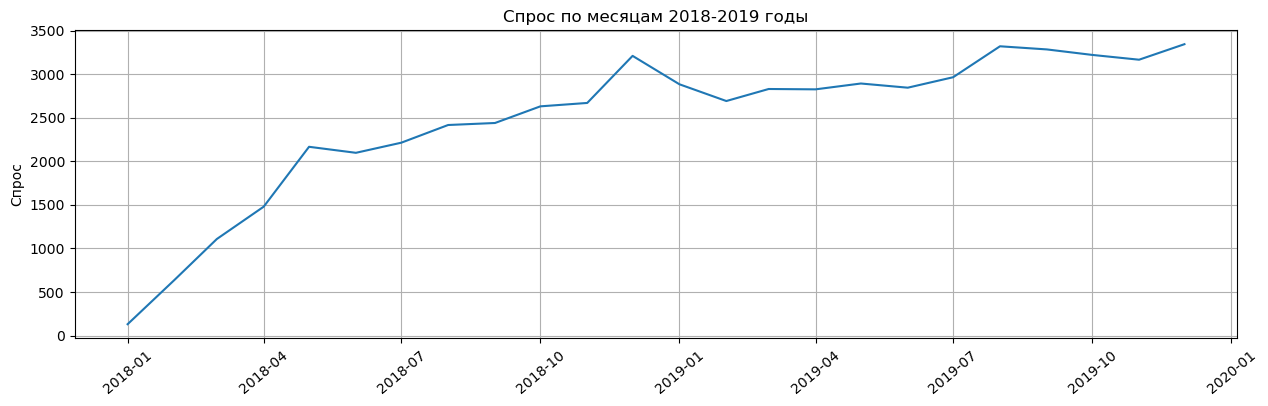

In [26]:
plt.figure(figsize=(15, 4))
plt.plot(all_data.groupby('Mon_Year').num_purchases.sum().index, all_data.groupby('Mon_Year').num_purchases.sum().values)
plt.xticks(rotation=40)
plt.ylabel("Спрос")
plt.grid()
plt.title('Спрос по месяцам 2018-2019 годы')
plt.show()

* график очень сильно растет с января 2018 по декабрь 2018
* возьмем только данные с октября 2018 года для дальнейшей работы

In [27]:
all_data_2019=all_data[all_data.dates>='2018-10-01']

In [28]:
len(all_data_2019)

8770

In [29]:
all_purch= all_data_2019.pivot_table(index='dates',columns='SKU', values='num_purchases')

In [30]:
all_purch.shape

(457, 39)

In [31]:
all_purch[:5]

SKU,10334,11050,17812,19632,24125,27240,27885,34130,36096,36108,...,72449,72784,80308,80631,82947,83329,84395,89272,90611,98255
dates,,,,,,,,,,,,,,,,,,,,,
2018-10-01,11.0,9.0,4.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,...,NaN,9.0,NaN,NaN,1.0,NaN,10.0,7.0,5.0,NaN
2018-10-02,11.0,NaN,5.0,NaN,NaN,NaN,2.0,1.0,NaN,NaN,...,NaN,8.0,NaN,NaN,1.0,NaN,10.0,8.0,6.0,7.0
2018-10-03,10.0,9.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,...,NaN,7.0,7.0,NaN,NaN,NaN,11.0,7.0,6.0,NaN
2018-10-04,NaN,9.0,4.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,8.0,9.0,NaN,1.0,NaN,12.0,8.0,NaN,NaN
2018-10-05,12.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,9.0,NaN,NaN,NaN,10.0,7.0,5.0,7.0


In [32]:
all_purch.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 457 entries, 2018-10-01 to 2019-12-31
Data columns (total 39 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   10334   330 non-null    float64
 1   11050   319 non-null    float64
 2   17812   310 non-null    float64
 3   19632   92 non-null     float64
 4   24125   52 non-null     float64
 5   27240   121 non-null    float64
 6   27885   204 non-null    float64
 7   34130   308 non-null    float64
 8   36096   102 non-null    float64
 9   36108   265 non-null    float64
 10  38767   312 non-null    float64
 11  39665   312 non-null    float64
 12  40194   267 non-null    float64
 13  43678   261 non-null    float64
 14  45164   317 non-null    float64
 15  48671   305 non-null    float64
 16  49596   184 non-null    float64
 17  49661   226 non-null    float64
 18  54404   272 non-null    float64
 19  57561   278 non-null    float64
 20  59567   93 non-null     float64
 21  59631   183 non-null

In [33]:
all_data_2019[:5]

,dates,SKU,price_per_sku,num_purchases,Mon_Year
42,2018-10-01,39665,87.368,2,2018-10-01
43,2018-10-02,39665,87.368,1,2018-10-01
44,2018-10-03,39665,87.368,2,2018-10-01
45,2018-10-06,39665,87.368,3,2018-10-01
46,2018-10-07,39665,87.368,2,2018-10-01


In [34]:
len(all_data.SKU.value_counts())

39

In [35]:
len(all_data_2019.SKU.value_counts())

39

* всего 39 SKU, после уменьшения выборки SKU не потеряны

Спрос по дням с октября 2018 года по конец 2019 года

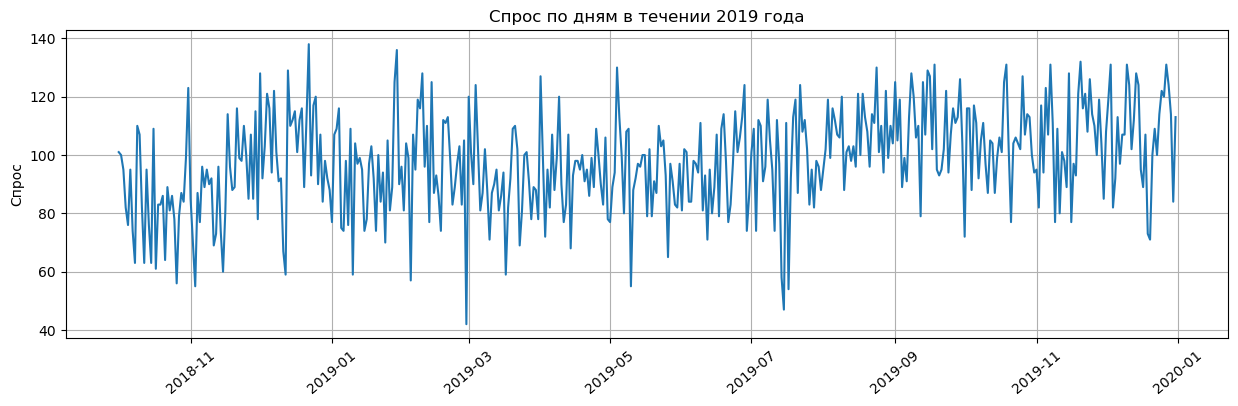

In [36]:
plt.figure(figsize=(15, 4))
plt.plot(all_data_2019.groupby('dates').num_purchases.sum().index, all_data_2019.groupby('dates').num_purchases.sum().values)
plt.xticks(rotation=40)
plt.ylabel("Спрос")
plt.grid()
plt.title('Спрос по дням в течении 2019 года')
plt.show()

## feature creation

In [37]:
all_data_2019['month']= all_data_2019.dates.dt.month

C:\Users\darya\AppData\Local\Temp\ipykernel_18792\4163607642.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_2019['month']= all_data_2019.dates.dt.month


In [38]:
all_data_2019['week_num']=all_data_2019.dates.dt.isocalendar().week

C:\Users\darya\AppData\Local\Temp\ipykernel_18792\3127794706.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_2019['week_num']=all_data_2019.dates.dt.isocalendar().week


In [39]:
all_data_2019['weekday']=all_data_2019.dates.dt.weekday

C:\Users\darya\AppData\Local\Temp\ipykernel_18792\356706032.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_2019['weekday']=all_data_2019.dates.dt.weekday


In [40]:
all_data_2019['quarter']=all_data_2019.dates.dt.quarter

C:\Users\darya\AppData\Local\Temp\ipykernel_18792\2954220131.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_2019['quarter']=all_data_2019.dates.dt.quarter


In [41]:
all_data_2019['daysinmonth']=all_data_2019.dates.dt.daysinmonth

C:\Users\darya\AppData\Local\Temp\ipykernel_18792\2707165267.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_2019['daysinmonth']=all_data_2019.dates.dt.daysinmonth


In [42]:
all_data_2019['year']=all_data_2019.dates.dt.year

C:\Users\darya\AppData\Local\Temp\ipykernel_18792\4102286435.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_2019['year']=all_data_2019.dates.dt.year


In [43]:
all_data_2019[:5]

,dates,SKU,price_per_sku,num_purchases,Mon_Year,month,week_num,weekday,quarter,daysinmonth,year
42,2018-10-01,39665,87.368,2,2018-10-01,10,40,0,4,31,2018
43,2018-10-02,39665,87.368,1,2018-10-01,10,40,1,4,31,2018
44,2018-10-03,39665,87.368,2,2018-10-01,10,40,2,4,31,2018
45,2018-10-06,39665,87.368,3,2018-10-01,10,40,5,4,31,2018
46,2018-10-07,39665,87.368,2,2018-10-01,10,40,6,4,31,2018


In [44]:
sku_dict=sku_dict.rename(columns={"sku_id": "SKU"})

In [45]:
all_data_2019

,dates,SKU,price_per_sku,num_purchases,Mon_Year,month,week_num,weekday,quarter,daysinmonth,year
42,2018-10-01,39665,87.368,2,2018-10-01,10,40,0,4,31,2018
43,2018-10-02,39665,87.368,1,2018-10-01,10,40,1,4,31,2018
44,2018-10-03,39665,87.368,2,2018-10-01,10,40,2,4,31,2018
45,2018-10-06,39665,87.368,3,2018-10-01,10,40,5,4,31,2018
46,2018-10-07,39665,87.368,2,2018-10-01,10,40,6,4,31,2018
...,...,...,...,...,...,...,...,...,...,...,...
254,2019-12-23,82947,NaN,1,2019-12-01,12,52,0,4,31,2019
255,2019-12-24,82947,195.460,2,2019-12-01,12,52,1,4,31,2019
256,2019-12-25,82947,195.210,1,2019-12-01,12,52,2,4,31,2019
257,2019-12-26,82947,193.790,1,2019-12-01,12,52,3,4,31,2019


In [46]:
data_df1=all_data_2019.merge(sku_dict, how='left', on= ['SKU'])

In [47]:
data_df1[:5]

,dates,SKU,price_per_sku,num_purchases,Mon_Year,month,week_num,weekday,quarter,daysinmonth,year,fincode,ui1_code,ui2_code,ui3_code,vendor,brand_code,creation_date,expiration_date
0,2018-10-01,39665,87.368,2,2018-10-01,10,40,0,4,31,2018,15,151,15100,1510001,4O4WSH,UEKGPFHF,2018-08-01,2020-01-01 00:00:00
1,2018-10-02,39665,87.368,1,2018-10-01,10,40,1,4,31,2018,15,151,15100,1510001,4O4WSH,UEKGPFHF,2018-08-01,2020-01-01 00:00:00
2,2018-10-03,39665,87.368,2,2018-10-01,10,40,2,4,31,2018,15,151,15100,1510001,4O4WSH,UEKGPFHF,2018-08-01,2020-01-01 00:00:00
3,2018-10-06,39665,87.368,3,2018-10-01,10,40,5,4,31,2018,15,151,15100,1510001,4O4WSH,UEKGPFHF,2018-08-01,2020-01-01 00:00:00
4,2018-10-07,39665,87.368,2,2018-10-01,10,40,6,4,31,2018,15,151,15100,1510001,4O4WSH,UEKGPFHF,2018-08-01,2020-01-01 00:00:00


In [48]:
data_df1.shape

(8770, 19)

In [49]:
data_df = data_df1.merge(promo_df, how='left', on= ['SKU','week_num', 'year'])

In [50]:
len(data_df)

8770

In [51]:
data_df.dtypes

dates              datetime64[ns]
SKU                         int64
price_per_sku             float64
num_purchases               int64
Mon_Year           datetime64[ns]
month                       int64
week_num                   UInt32
weekday                     int64
quarter                     int64
daysinmonth                 int64
year                        int64
fincode                    object
ui1_code                   object
ui2_code                   object
ui3_code                   object
vendor                     object
brand_code                 object
creation_date              object
expiration_date            object
discount                  float64
dtype: object

In [52]:
data_df.isnull().sum()

dates                 0
SKU                   0
price_per_sku        56
num_purchases         0
Mon_Year              0
month                 0
week_num              0
weekday               0
quarter               0
daysinmonth           0
year                  0
fincode               0
ui1_code              0
ui2_code              0
ui3_code              0
vendor                0
brand_code            0
creation_date         0
expiration_date       0
discount           8489
dtype: int64

In [53]:
data_df[['dates','Mon_Year']]=data_df[['dates','Mon_Year']].astype(str)

In [54]:
data_df.dropna(subset=['price_per_sku'],inplace = True)

In [55]:
data_df.discount.fillna(1, inplace = True)

In [56]:
data_df.discount.value_counts()

1.00    8433
0.90     140
0.95      86
0.80      55
Name: discount, dtype: int64

In [57]:
data_df['past_demand'] = data_df.groupby('SKU')['num_purchases'].shift(1)
data_df['past_price'] = data_df.groupby('SKU')['price_per_sku'].shift(1)

# train-test split

* Формирую выборки так, чтобы в тренировочный набор попали все представленные 39 SKU. 

In [58]:
data_df.dropna(inplace =True)

In [59]:
train_df1=data_df[data_df.dates<'2019-11-01']

In [60]:
data_df[data_df.dates<'2019-11-01'].shape

(7341, 22)

In [61]:
len(data_df[data_df.dates<'2019-11-01'].SKU.value_counts())

39

In [62]:
test_df1=data_df[data_df.dates>='2019-11-01']

In [63]:
data_df[data_df.dates>='2019-11-01'].shape

(1334, 22)

In [64]:
1334/data_df.shape[0]

0.15377521613832854

In [65]:
len(data_df[data_df.dates>='2019-11-01'].SKU.value_counts())

31

* Все тестовые SKU есть в тренировочном наборе: 

In [66]:

for i in set(test_df1.SKU):
    if i not in set(train_df1.SKU):
        print(i)

* Разделение на данные и метки

In [67]:
def X_y(train_df1, test_df1, TARGET_COLUMN):
    x_columns = train_df1.columns
    x_columns = x_columns[x_columns != TARGET_COLUMN]
    y_train1 = train_df1[TARGET_COLUMN]
    X_train1 = train_df1[x_columns]
    y_test1 = test_df1[TARGET_COLUMN]
    X_test1 = test_df1[x_columns]
    return X_train1, y_train1, X_test1, y_test1

In [68]:

X_train1, y_train1, X_test1, y_test1= X_y(train_df1, test_df1,'num_purchases')

# Demand forecast

## Linear regression

In [69]:
lin_reg = LinearRegression().fit(X_train1[['price_per_sku','SKU','week_num','weekday','quarter', 'daysinmonth','discount', 'past_demand','past_price']],
                                 y_train1)

In [70]:
y_pred_lr_dem = lin_reg.predict(X_test1[['price_per_sku','SKU','week_num','weekday','quarter', 'daysinmonth','discount', 'past_demand','past_price']])

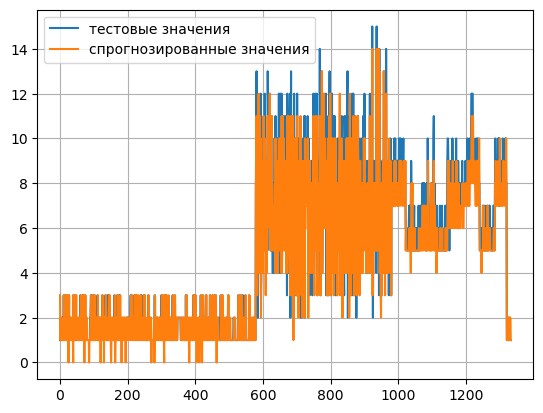

In [71]:
plt.plot(range(len(y_test1)), y_test1, label= 'тестовые значения')
plt.plot(range(len(y_test1)), np.floor(y_pred_lr_dem), label= 'спрогнозированные значения')
plt.grid()
plt.legend()

### Metrics LinReg num_purchases

In [72]:
mean_squared_error(y_test1, y_pred_lr_dem, squared= False)

1.1015690811549312

In [73]:
r2_score(y_test1,  y_pred_lr_dem)

0.9018335889197401

In [74]:
data_df[:-2].dtypes.index

Index(['dates', 'SKU', 'price_per_sku', 'num_purchases', 'Mon_Year', 'month',
       'week_num', 'weekday', 'quarter', 'daysinmonth', 'year', 'fincode',
       'ui1_code', 'ui2_code', 'ui3_code', 'vendor', 'brand_code',
       'creation_date', 'expiration_date', 'discount', 'past_demand',
       'past_price'],
      dtype='object')

## CatBoostRegressor

In [75]:
model_cb = cb.CatBoostRegressor(cat_features=['dates', 'SKU','Mon_Year', 'month',
       'week_num', 'weekday', 'quarter', 'daysinmonth', 'year', 'fincode',
       'ui1_code', 'ui2_code', 'ui3_code', 'vendor', 'brand_code',
       'creation_date', 'expiration_date'], silent=True)
                                     

In [76]:
model_cb.fit(X_train1.iloc[:,:-2], y_train1)

In [77]:
y_pred_cb_dem = model_cb.predict(X_test1)

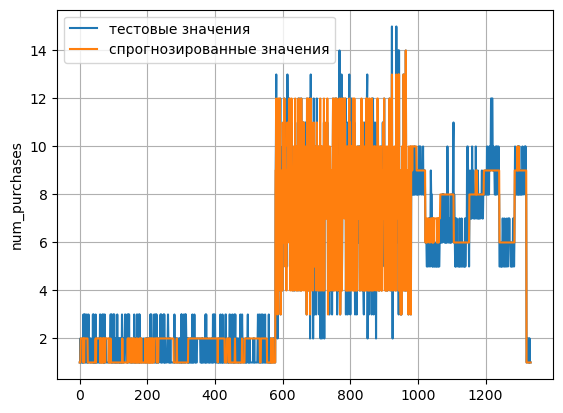

In [78]:
plt.plot(range(len(y_pred_cb_dem)), y_test1, label= 'тестовые значения')
plt.plot(range(len(y_pred_cb_dem)), np.floor(y_pred_cb_dem), label= 'спрогнозированные значения')
plt.ylabel('num_purchases')
plt.grid()
plt.legend()

### Metrics CatBoostReg num_purchases

In [79]:
# baseline
mean_squared_error(y_test1, np.full((len(y_test1), 1),y_test1.mean()))

12.361197961738773

* RMSE для тестового набора = 0.99: 

In [80]:
mean_squared_error(y_test1, y_pred_cb_dem, squared= False)

1.1250473315388425

Хотя необходимая метрика - это RMSE, также очень важная для понимания качетсва прогноза R2

In [81]:
r2_score(y_test1, y_pred_cb_dem)

0.8976044634087692

* Интерпретирую результаты, какие фичи повлияли более всего на прогноз 

In [82]:
def Interpret(importances,X_test1):
    plt.figure(figsize=(10, 5))
    for i,v in enumerate(importances):
        plt.bar([x for x in X_test1.columns], importances)
    plt.title('Интерпретация признаков')
    plt.xticks(rotation=90)
    plt.show()

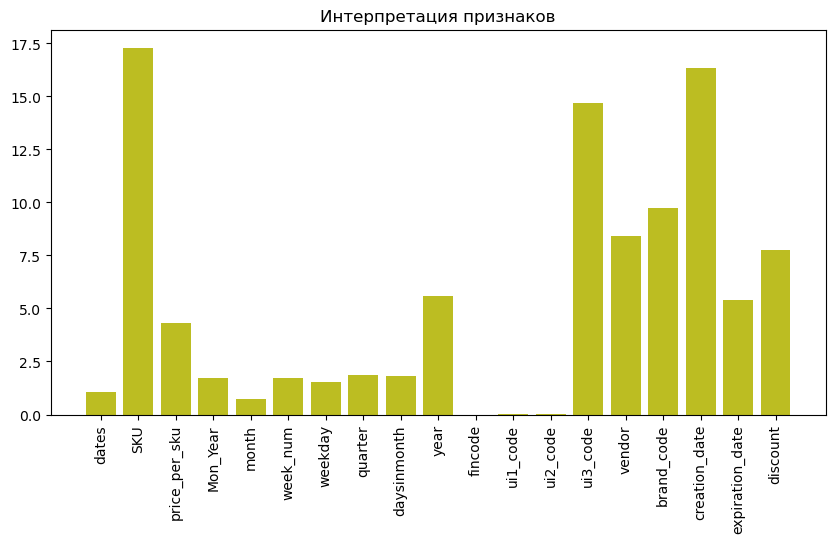

In [83]:
Interpret(model_cb.feature_importances_, X_test1.iloc[:,:-2])

* Почти все фичи за иключением fincode, ui1_code, ui2_code  влияют на прогноз

### RMSE для каждого SKU

In [84]:
y_pred_cb_dem = (np.floor(y_pred_cb_dem).astype(int))

In [85]:
y_pred_lr_dem = (np.floor(y_pred_lr_dem).astype(int))

In [86]:
X=pd.concat([X_test1['SKU'].reset_index(drop=True),
             y_test1.reset_index(drop=True),  
             pd.Series(y_pred_cb_dem), 
             pd.Series(y_pred_lr_dem),
            X_test1['price_per_sku'].reset_index(drop=True)], axis = 1)

In [87]:
X.rename(columns={0: 'y_pred_num_purches_cb',
                 1: 'y_pred_num_purches_lr'}, inplace =True)

In [88]:
X

,SKU,num_purchases,y_pred_num_purches_cb,y_pred_num_purches_lr,price_per_sku
0,39665,1,1,3,92.975
1,39665,1,1,1,92.975
2,39665,2,1,1,92.975
3,39665,1,2,2,91.064
4,39665,1,2,1,91.064
...,...,...,...,...,...
1329,82947,1,1,2,195.960
1330,82947,2,1,1,195.460
1331,82947,1,1,2,195.210
1332,82947,1,1,1,193.790


In [89]:
X['rse_cb'] = ((X.y_pred_num_purches_cb - X.num_purchases)**2)**0.5
X['rse_lr'] = ((X.y_pred_num_purches_lr - X.num_purchases)**2)**0.5

In [90]:
#root mean square error для каждого SKU CatBoost
X.groupby('SKU').rse_cb.mean()

SKU
10334    0.642857
11050    0.604651
17812    0.850000
19632    1.275000
27240    0.714286
34130    0.565217
36096    0.666667
36108    0.636364
38767    0.777778
39665    0.659574
40194    0.723404
43678    0.895833
45164    0.432432
48671    0.627907
49596    0.700000
49661    0.742857
54404    0.857143
59631    0.711111
63995    0.708333
64619    0.581395
70252    0.659574
70315    0.600000
72449    0.520833
72784    0.914894
80308    1.021739
80631    0.711111
82947    0.384615
83329    0.446809
84395    1.000000
89272    1.068182
90611    0.585366
Name: rse_cb, dtype: float64

In [91]:
X.groupby('SKU').rse_cb.mean().min()

0.38461538461538464

In [92]:
X.groupby('SKU').rse_cb.mean().max()

1.275

In [93]:
#root mean square error для каждого SKU linReg
X.groupby('SKU').rse_lr.mean()

SKU
10334    1.095238
11050    1.116279
17812    1.150000
19632    1.325000
27240    0.833333
34130    0.717391
36096    1.125000
36108    0.568182
38767    1.155556
39665    1.000000
40194    0.574468
43678    1.125000
45164    0.702703
48671    0.883721
49596    0.800000
49661    1.257143
54404    1.214286
59631    0.622222
63995    0.833333
64619    0.813953
70252    0.914894
70315    0.822222
72449    0.625000
72784    1.191489
80308    0.826087
80631    0.622222
82947    0.384615
83329    1.063830
84395    1.239130
89272    0.795455
90611    0.926829
Name: rse_lr, dtype: float64

In [94]:
X.groupby('SKU').rse_lr.mean().min()

0.38461538461538464

In [95]:
X.groupby('SKU').rse_lr.mean().max()

1.325

### Вывод1

в задаче прогнозирования спроса построены две модели:
* linear regression с RMSE для тестового набора = 1.1, baseline rmse = 12.3, R2 = 0.87
* CatBoostReg с RMSE для тестового набора = 0.99, baseline rmse = 12.3, R2 = 0.92


# Linear regression цены от спроса

Линейная регрессия — это статистический метод, который помогает нам понять линейную связь между двумя переменными. В контексте прогнозирования спроса это означает определение того, как отдельный фактор (например, цена или расходы на маркетинг) влияет на потребительский спрос.

In [100]:
lin_reg1 = LinearRegression().fit(test_df1[['num_purchases','SKU']], test_df1['price_per_sku'])

In [101]:
y_pred_lr=lin_reg1.predict(np.array(test_df1[['num_purchases','SKU']]))

C:\Users\darya\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [102]:
# Baseline 

mean_squared_error(X['price_per_sku'], np.full((len(X['price_per_sku']), 1),X['price_per_sku'].mean()), squared= False)

28.865375293930352

In [103]:
mean_squared_error(X['price_per_sku'], y_pred_lr, squared= False)

28.736160029629676

In [104]:
r2_score(y_test1, y_pred_lr)

-1024.8565918979828

### Вывод2 

* Линейная модель хорошо прогнозирует спрос, используя следующие фичи: ['price_per_sku','SKU','week_num','weekday','quarter', 'daysinmonth','discount', 'past_demand','past_price']
* но с задачей прогноза цены на основе только одного спроса, не дает результата с требуемой точностью 

* Использую также кэтбуст и все представленные фичи для прогноза цены

# Прогноз цены с помощью CATBOOST

In [105]:
X_train2, y_train2, X_test2, y_test2= X_y(train_df1, test_df1,'price_per_sku')

In [106]:
X_train2.columns

Index(['dates', 'SKU', 'num_purchases', 'Mon_Year', 'month', 'week_num',
       'weekday', 'quarter', 'daysinmonth', 'year', 'fincode', 'ui1_code',
       'ui2_code', 'ui3_code', 'vendor', 'brand_code', 'creation_date',
       'expiration_date', 'discount', 'past_demand', 'past_price'],
      dtype='object')

In [107]:
model_cb2 = cb.CatBoostRegressor(cat_features=['dates', 'SKU','Mon_Year', 'month',
       'week_num', 'weekday', 'quarter', 'daysinmonth', 'year', 'fincode',
       'ui1_code', 'ui2_code', 'ui3_code', 'vendor', 'brand_code',
       'creation_date', 'expiration_date'], silent=True)
model_cb2.fit(X_train2, y_train2)

In [108]:
y_pred_cb_pr = model_cb2.predict(X_test2)

* Получаю rmse ~2.5, что соответсвует условию задачи (rmse < 10)

In [109]:
mean_squared_error(y_test2, y_pred_cb_pr, squared= False)

2.425768666628588

In [110]:
r2_score(y_test2, y_pred_cb_pr)

0.992937729510235

In [111]:
y_pred_cb_pr = (np.floor(y_pred_cb_pr).astype(int))

In [122]:
X_pr=pd.concat([X_test2['dates'].reset_index(drop=True),
    X_test2['SKU'].reset_index(drop=True),
             y_test2.reset_index(drop=True),  
             pd.Series(y_pred_cb_pr), 
            X_test2['num_purchases'].reset_index(drop=True)], axis = 1)

In [123]:
X_pr.rename(columns={0: 'y_pred_prices_cb',
                 }, inplace =True)

In [124]:
X_pr

,dates,SKU,price_per_sku,y_pred_prices_cb,num_purchases
0,2019-11-01,39665,92.975,91,1
1,2019-11-02,39665,92.975,91,1
2,2019-11-03,39665,92.975,91,2
3,2019-11-05,39665,91.064,91,1
4,2019-11-06,39665,91.064,89,1
...,...,...,...,...,...
1329,2019-12-21,82947,195.960,206,1
1330,2019-12-24,82947,195.460,206,2
1331,2019-12-25,82947,195.210,206,1
1332,2019-12-26,82947,193.790,206,1


In [115]:
X_pr['rmse'] = ((X_pr.y_pred_prices_cb - X_pr.price_per_sku)**2)**0.5

In [116]:
#root mean square error для каждого SKU
X_pr.groupby('SKU').rmse.mean()

SKU
10334    3.074281
11050    3.193349
17812    2.740515
19632    2.011650
27240    0.725357
34130    2.823000
36096    1.133300
36108    2.188591
38767    2.778400
39665    2.501383
40194    1.781340
43678    2.240708
45164    2.498108
48671    2.610256
49596    1.480550
49661    4.248457
54404    2.645786
59631    2.618800
63995    1.934938
64619    1.902209
70252    1.852255
70315    2.733489
72449    2.769396
72784    1.818723
80308    1.605522
80631    3.295689
82947    7.300769
83329    2.602798
84395    2.782370
89272    2.826045
90611    3.564351
Name: rmse, dtype: float64

In [117]:
X_pr.groupby('SKU').rmse.mean().min()

0.7253571428571419

In [118]:
X_pr.groupby('SKU').rmse.mean().max()

7.30076923076923

Text(0.5, 1.0, 'Спрогнозированная и реальная цена по каждому из SKU')

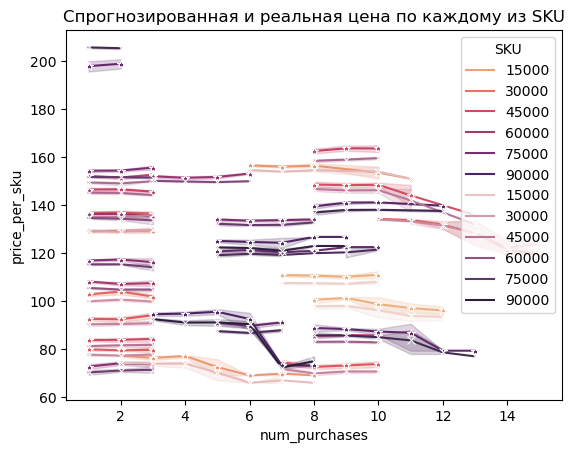

In [119]:
sns.lineplot(data = X_pr, y='price_per_sku',x='num_purchases', hue = 'SKU', palette="flare", marker = '*')
sns.lineplot(data = X_pr, y='y_pred_prices_cb',x='num_purchases', hue = 'SKU', marker = 'x' )
plt.title('Спрогнозированная и реальная цена по каждому из SKU')

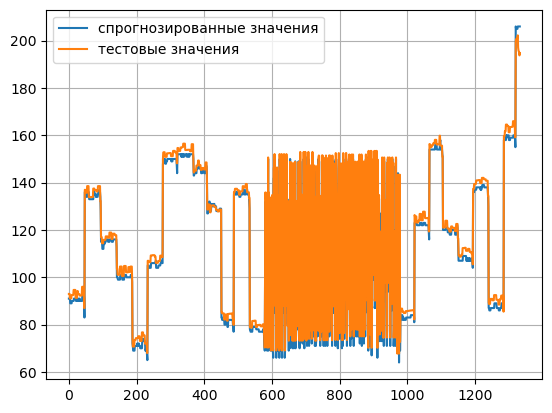

In [120]:
plt.plot(range(len(y_test2)), y_pred_cb_pr, label= 'спрогнозированные значения')
plt.plot(range(len(y_test2)),y_test2, label= 'тестовые значения')
plt.grid()
plt.legend()

* Интерпретация результата

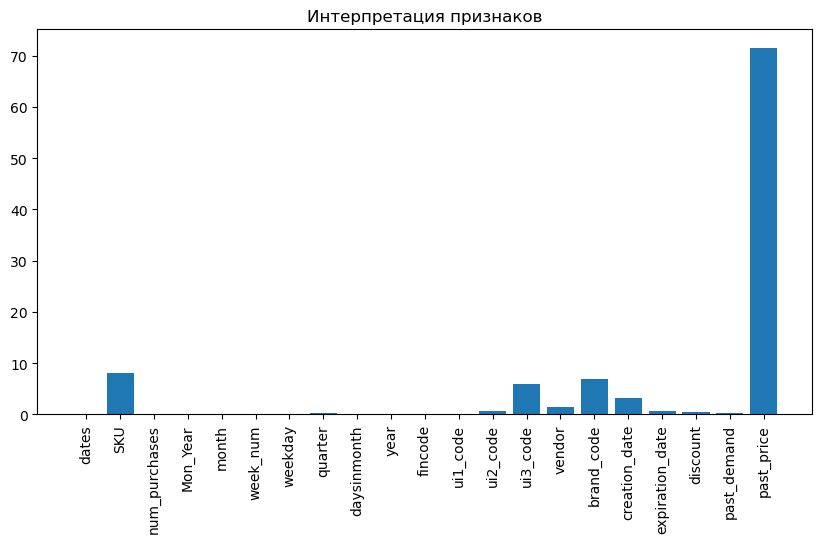

In [121]:
Interpret(model_cb2.feature_importances_, X_test2)

### Вывод 3

* Метрики прогноза цены R2 = 0.992, RMSE = 2.42

* Из интерпретации можно сказать, что только значения предыдущей цены вносят огромный вклад в прогноcтичность модели

In [130]:
X_pr[['dates','SKU','y_pred_prices_cb']].to_csv('prediction.csv', index = False)

In [131]:
 pd.read_csv('prediction.csv')

,dates,SKU,y_pred_prices_cb
0,2019-11-01,39665,91
1,2019-11-02,39665,91
2,2019-11-03,39665,91
3,2019-11-05,39665,91
4,2019-11-06,39665,89
...,...,...,...
1329,2019-12-21,82947,206
1330,2019-12-24,82947,206
1331,2019-12-25,82947,206
1332,2019-12-26,82947,206
